In [1]:
import numpy as np
import pandas as pd
from numpy.random import randn
from shapedtw.shapedtw import shape_dtw
from shapedtw.shapeDescriptors import SlopeDescriptor, PAADescriptor, CompoundDescriptor
from shapedtw.dtwPlot import dtwPlot

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



<Axes: >

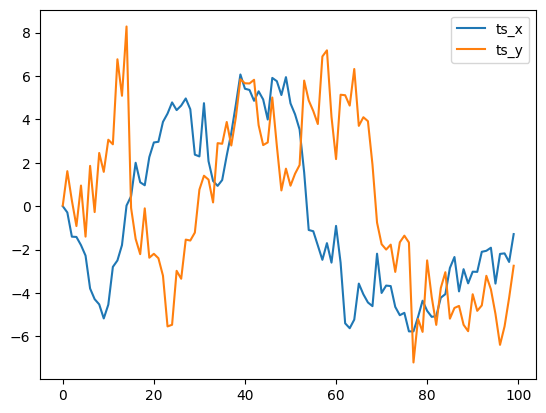

In [2]:
np.random.seed(9)
distortion_factor = 1
ts_x = np.cumsum(randn(100))
ts_y = np.concatenate(
    (
        np.cumsum(randn(15)),
        ts_x[:85]
    )
) + (randn(100)*distortion_factor)

df = pd.DataFrame({"ts_x": ts_x, "ts_y": ts_y})
df.plot()

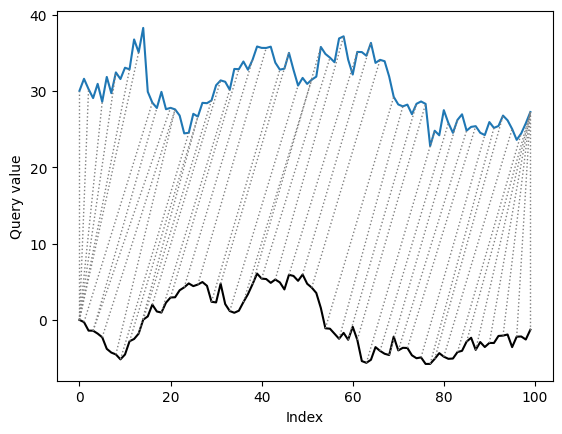

In [3]:
slope_descriptor = SlopeDescriptor(slope_window=5)
paa_descriptor = PAADescriptor(piecewise_aggregation_window=5)
compound_descriptor = CompoundDescriptor([slope_descriptor, paa_descriptor],descriptors_weights=[5., 1.])

shape_dtw_results = shape_dtw(
    x=ts_x,
    y=ts_y,
    subsequence_width=20,
    shape_descriptor=compound_descriptor
)

dtwPlot(shape_dtw_results, plot_type="twoway", yoffset = 30)

In [4]:
print(round(shape_dtw_results.distance, 2))
print(round(shape_dtw_results.normalized_distance, 2))
print(round(shape_dtw_results.shape_distance, 2))
print(round(shape_dtw_results.shape_normalized_distance, 2))

196.58
0.98
1276.43
6.38


### Calculation process in details

Define short, univariate time series and transform them to subsequences

NB: We can consider standard dtw as a special case of shape dtw with subsequence_width=0 and RawSubsequenceDescriptor as a shape descriptor.

In [5]:
import numpy as np
from shapedtw.preprocessing import UnivariateSubsequenceBuilder

subsequence_width = 1 #controls the width of subsequence

ts_x = np.array([1, 2, 3, 4])
ts_y = np.array([11, 12, 13, 14])

ts_x_subsequences = UnivariateSubsequenceBuilder(ts_x, subsequence_width).transform_time_series_to_subsequences()
ts_y_subsequences = UnivariateSubsequenceBuilder(ts_y, subsequence_width).transform_time_series_to_subsequences()

print(ts_x_subsequences.subsequences)
print(ts_y_subsequences.subsequences)

[[1 1 2]
 [1 2 3]
 [2 3 4]
 [3 4 4]]
[[11 11 12]
 [11 12 13]
 [12 13 14]
 [13 14 14]]


Calculate shape descriptors for all subsequences using the PAA descriptor

In [6]:
from shapedtw.shapeDescriptors import PAADescriptor

paa_descriptor = PAADescriptor(piecewise_aggregation_window=2) #split subsequences into disjoint intervals

ts_x_shape_descriptors = ts_x_subsequences.get_shape_descriptors(paa_descriptor)
ts_y_shape_descriptors = ts_y_subsequences.get_shape_descriptors(paa_descriptor)

print(ts_x_shape_descriptors.shape_descriptors_array)
print(ts_y_shape_descriptors.shape_descriptors_array)

[[1.  2. ]
 [1.5 3. ]
 [2.5 4. ]
 [3.5 4. ]]
[[11.  12. ]
 [11.5 13. ]
 [12.5 14. ]
 [13.5 14. ]]


Copmute the distance matrix between the shape descriptors

In [7]:
from dtw import dtw

distance_matrix = ts_x_shape_descriptors.calc_distance_matrix(ts_y_shape_descriptors)
dtw_results = dtw(distance_matrix.dist_matrix)

print(round(dtw_results.distance, 2))
print(round(dtw_results.normalizedDistance, 2))

89.5
11.19


The distance calculated in such a way is a distance between shape descriptors of time series, not time series itself. Of course it can be treated as a distance measure and used for example to find nearest neighbour in classification tasks, however one can prefer to use distance between raw values of time series. In order to reconstruct such distance, we can use DistanceReconstructor class.

In [8]:
from shapedtw.shapedtw import DistanceReconstructor

dist_reconstructor = DistanceReconstructor(
    step_pattern="symmetric2",
    ts_x=ts_x,
    ts_y=ts_y,
    ts_x_wp=dtw_results.index1s,
    ts_y_wp=dtw_results.index2s,
    dist_method="euclidean"
)

raw_ts_distance = dist_reconstructor.calc_raw_ts_distance()
print(round(raw_ts_distance, 2))

61.0


## Multidimensional variants of shape dtw

In [9]:
import numpy as np
from numpy.random import randn
from shapedtw.shapedtw import shape_dtw
from shapedtw.dtwPlot import dtwPlot
from shapedtw.shapeDescriptors import SlopeDescriptor

np.random.seed(9)
ts_x = np.cumsum(randn(50, 2), axis=0)
ts_y = np.cumsum(randn(50, 2), axis=0)

slope_descriptor = SlopeDescriptor(slope_window=3)
subsequence_width = 3

shape_dtw_dependent_results = shape_dtw(
    x=ts_x,
    y=ts_y,
    subsequence_width=subsequence_width,
    shape_descriptor=slope_descriptor,
    multivariate_version="dependent"
    
)
shape_dtw_independent_results = shape_dtw(
    x=ts_x,
    y=ts_y,
    subsequence_width=subsequence_width,
    shape_descriptor=slope_descriptor,
    multivariate_version="independent"
    
)

dependent_distance = round(shape_dtw_dependent_results.distance, 2)
independent_distance = round(shape_dtw_independent_results.distance, 2)

print(dependent_distance)
print(independent_distance)

740.77
956.44


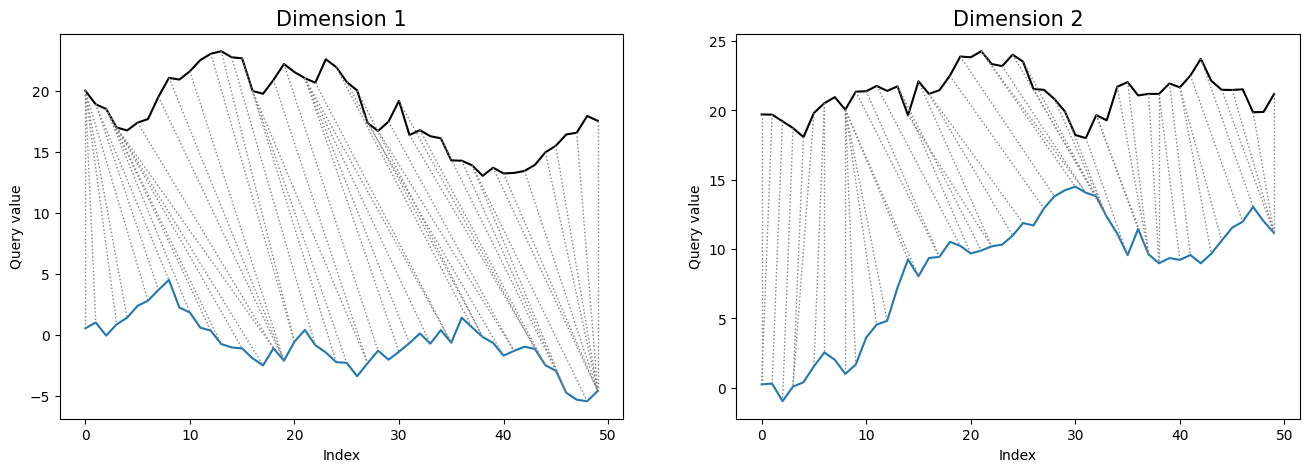

In [10]:
dtwPlot(shape_dtw_independent_results, plot_type="twoway", xoffset=20)

Various plotting styles are available, passing strings to the type argument (may be abbreviated):
- alignment plots the warping curve in d;
- twoway plots a point-by-point comparison, with matching lines; see [dtwPlotTwoWay()];
- threeway vis-a-vis inspection of the timeseries and their warping curve; see [dtwPlotThreeWay()];
- density displays the cumulative cost landscape with the warping path overimposed; see [dtwPlotDensity()]

## DTW parameters

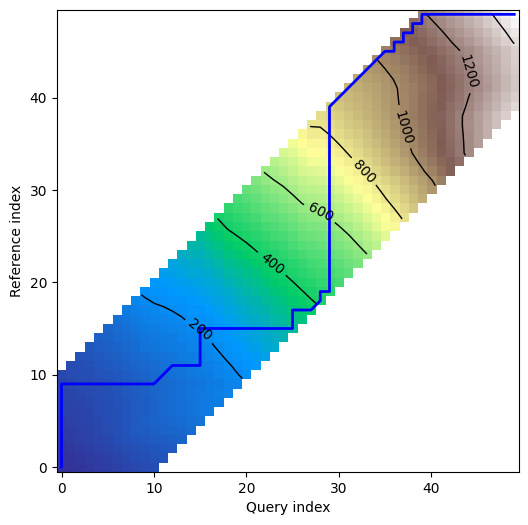

In [11]:
import numpy as np
from numpy.random import randn
from shapedtw.shapedtw import shape_dtw
from shapedtw.dtwPlot import dtwPlot
from shapedtw.shapeDescriptors import SlopeDescriptor

np.random.seed(3)
ts_x = np.cumsum(randn(50))
ts_y = np.cumsum(randn(50))

slope_descriptor = SlopeDescriptor(slope_window=3)

shape_dtw_res = shape_dtw(
    x=ts_x,
    y=ts_y,
    subsequence_width=3,
    shape_descriptor=paa_descriptor,
    window_type="sakoechiba",
    window_args={"window_size": 10},
    keep_internals=True
)

dtwPlot(shape_dtw_res, plot_type="density")

## Plots

### Plots - univariate case

In [12]:
import numpy as np
from numpy.random import randn
from shapedtw.shapedtw import shape_dtw
from shapedtw.dtwPlot import dtwPlot
from shapedtw.shapeDescriptors import SlopeDescriptor

np.random.seed(6)
ts_x = np.cumsum(randn(50))
ts_y = np.cumsum(randn(50))

slope_descriptor = SlopeDescriptor(slope_window=3)

shape_dtw_res = shape_dtw(
    x=ts_x,
    y=ts_y,
    subsequence_width=3,
    shape_descriptor=paa_descriptor,
    keep_internals=True
)

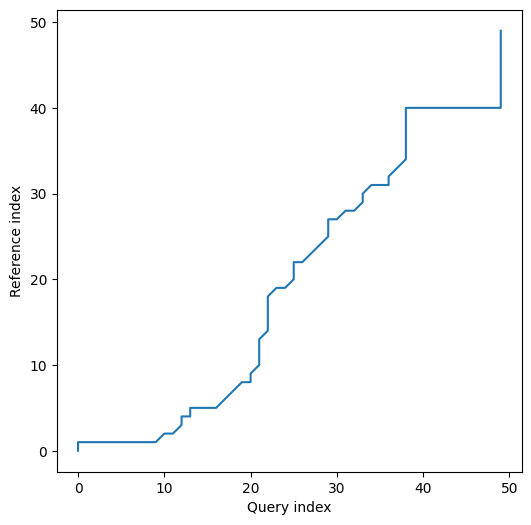

<Axes: xlabel='Query index', ylabel='Reference index'>

In [13]:
dtwPlot(shape_dtw_res, plot_type="alignment")

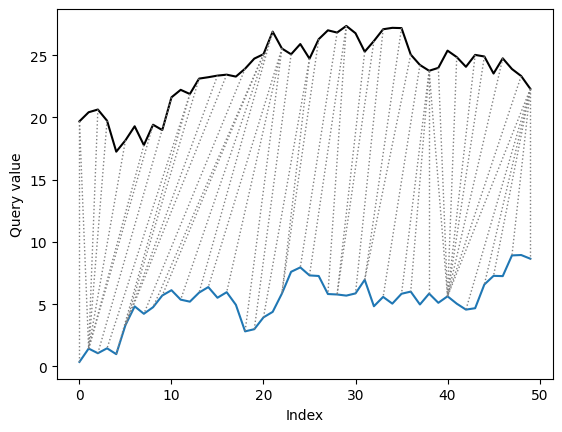

In [14]:
dtwPlot(shape_dtw_res, plot_type="twoway", xoffset=20)

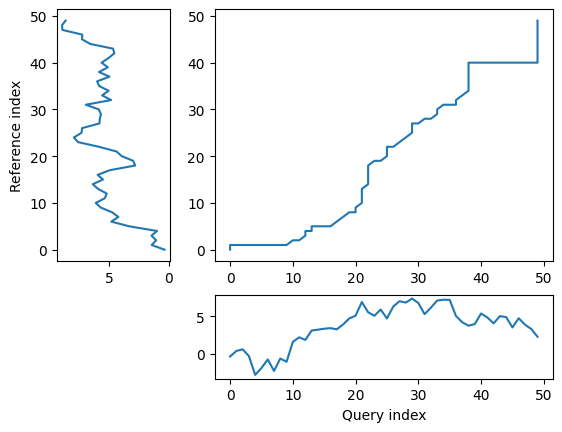

In [15]:
dtwPlot(shape_dtw_res, plot_type="threeway")

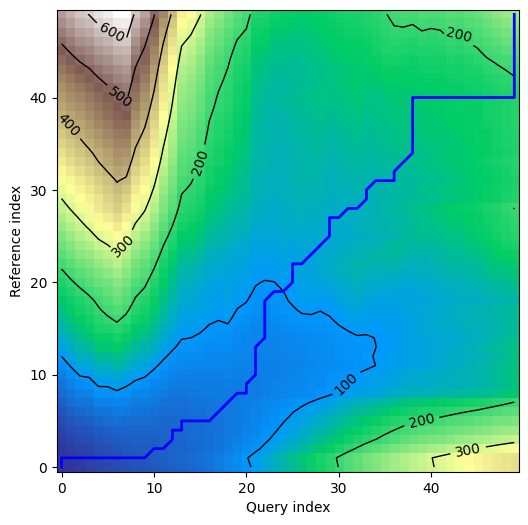

In [16]:
dtwPlot(shape_dtw_res, plot_type="density")

### Plots - multivariate dependent variant

In [17]:
import numpy as np
from numpy.random import randn
from shapedtw.shapedtw import shape_dtw
from shapedtw.dtwPlot import dtwPlot
from shapedtw.shapeDescriptors import SlopeDescriptor

np.random.seed(7)
ts_x = np.cumsum(randn(50, 2), axis=0)
ts_y = np.cumsum(randn(50, 2), axis=0)

slope_descriptor = SlopeDescriptor(slope_window=3)

shape_dtw_res = shape_dtw(
    x=ts_x,
    y=ts_y,
    subsequence_width=3,
    shape_descriptor=paa_descriptor,
    keep_internals=True,
    multivariate_version="dependent"
)

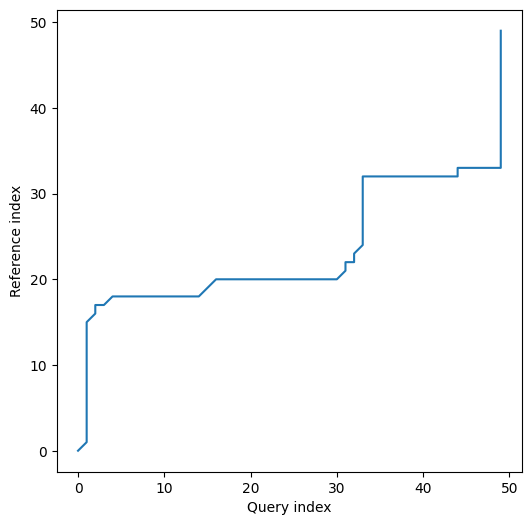

<Axes: xlabel='Query index', ylabel='Reference index'>

In [18]:
dtwPlot(shape_dtw_res, plot_type="alignment")

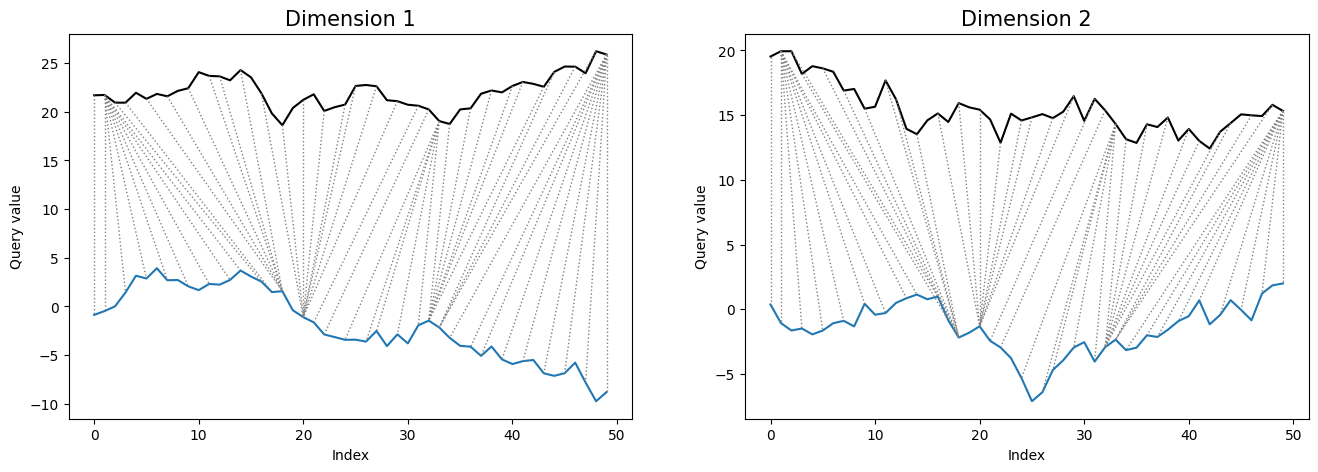

In [19]:
dtwPlot(shape_dtw_res, plot_type="twoway", xoffset=20)

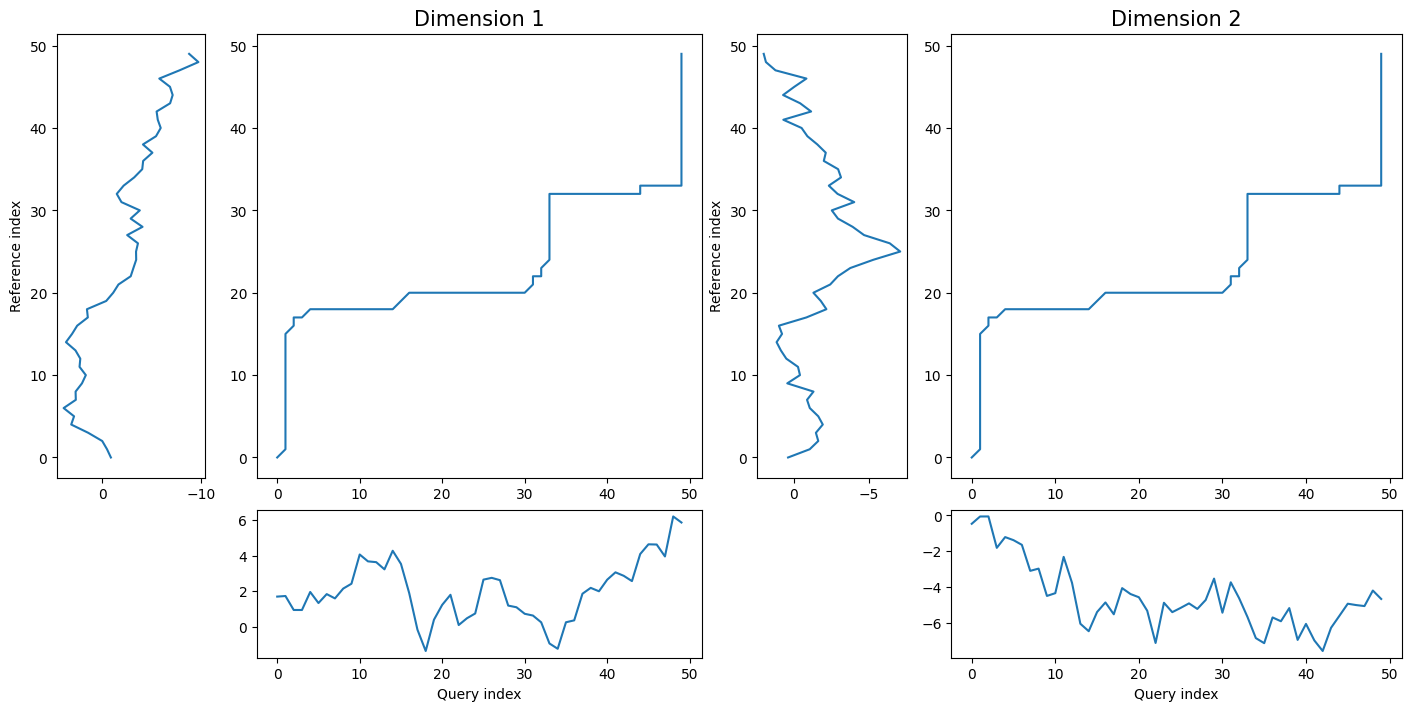

In [20]:
dtwPlot(shape_dtw_res, plot_type="threeway")

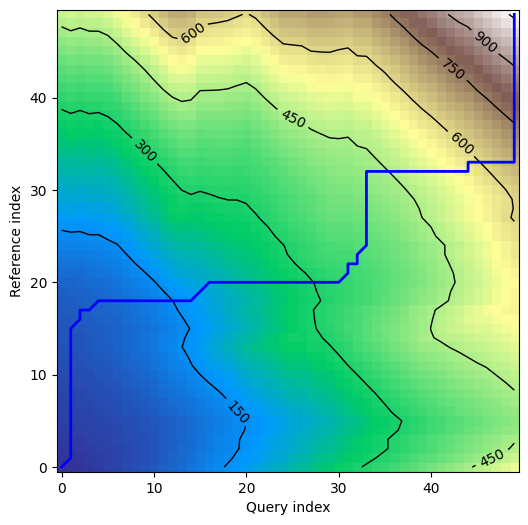

In [21]:
dtwPlot(shape_dtw_res, plot_type="density")

### Plots - multivariate independent variant

In [22]:
import numpy as np
from numpy.random import randn
from shapedtw.shapedtw import shape_dtw
from shapedtw.dtwPlot import dtwPlot
from shapedtw.shapeDescriptors import SlopeDescriptor

np.random.seed(7)
ts_x = np.cumsum(randn(50, 2), axis=0)
ts_y = np.cumsum(randn(50, 2), axis=0)

slope_descriptor = SlopeDescriptor(slope_window=3)

shape_dtw_res = shape_dtw(
    x=ts_x,
    y=ts_y,
    subsequence_width=3,
    shape_descriptor=paa_descriptor,
    keep_internals=True,
    multivariate_version="independent"
)

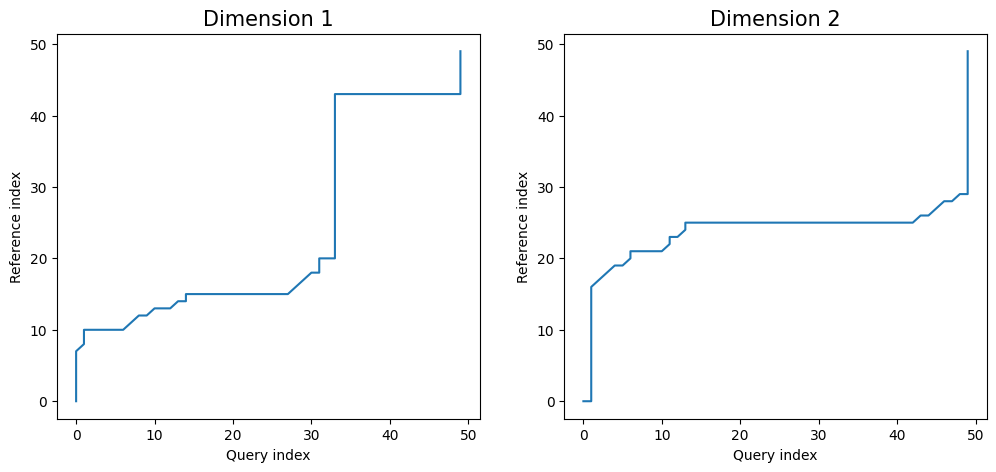

In [23]:
dtwPlot(shape_dtw_res, plot_type="alignment")

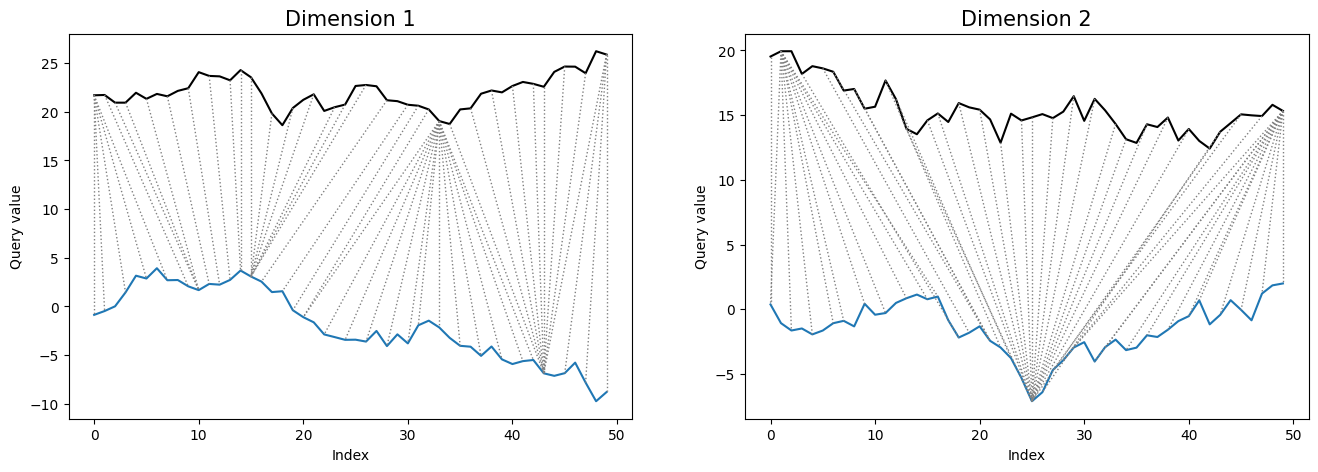

In [24]:
dtwPlot(shape_dtw_res, plot_type="twoway", xoffset=20)

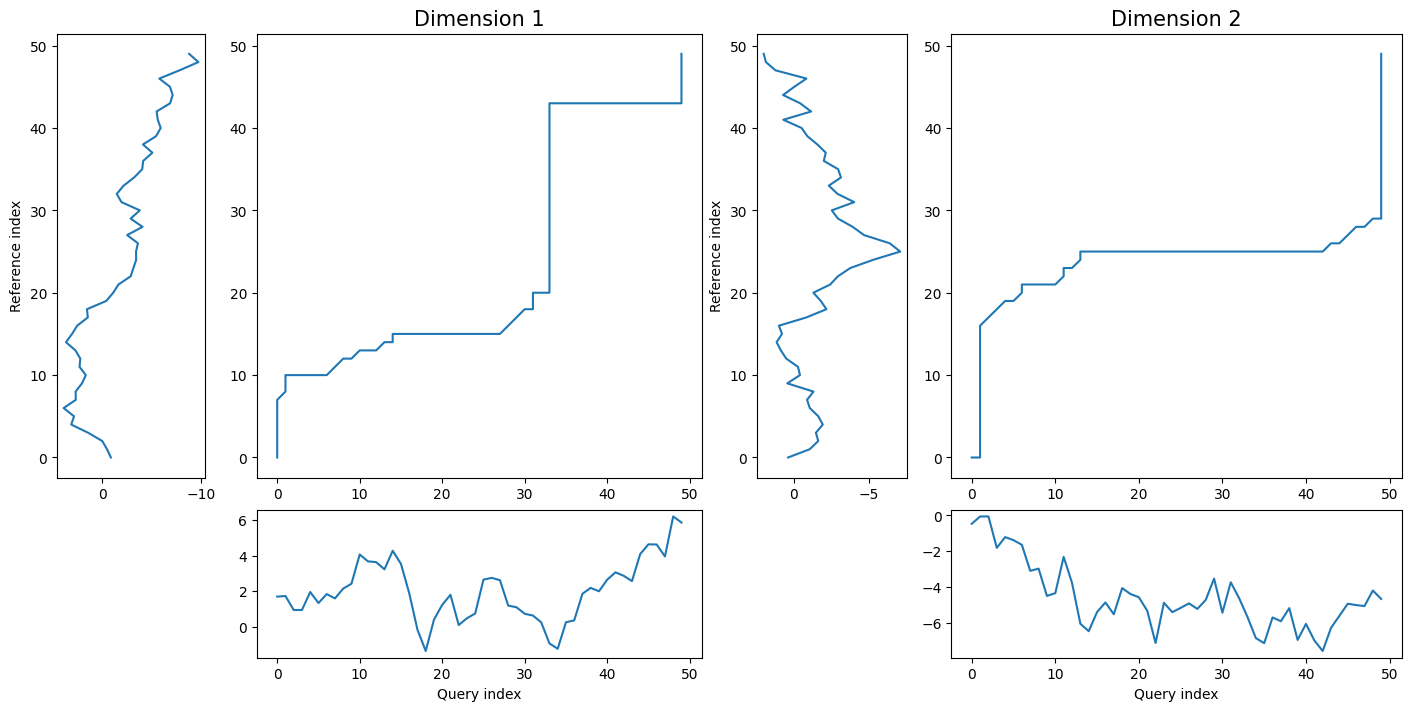

In [25]:
dtwPlot(shape_dtw_res, plot_type="threeway")

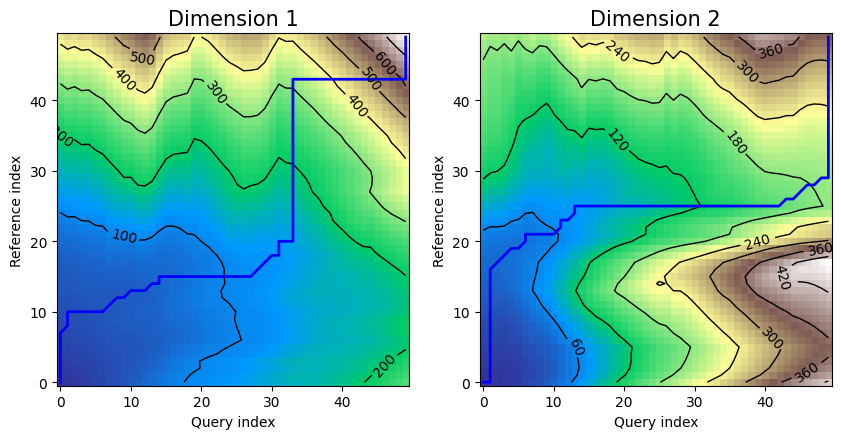

In [26]:
dtwPlot(shape_dtw_res, plot_type="density")